In [2]:
import gzip
import json
import os
import sys
from os import PathLike, path
from paramiko.client import SSHClient, AutoAddPolicy
from typing import List, Tuple, TypeAlias, Generator, Iterable
from huggingface_hub import list_datasets
from datasets import load_dataset, load_dataset_builder
from itertools import islice
from transformers import AutoTokenizer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from functools import wraps, reduce
import shutil
from util import ssh_alvis



## Generate

In [23]:
# Generate a pandas table with information whether files exist or not. Rows are samples/results and columns are locations.
from util import ALVIS_BASE_DIR


data_dir_path_map = {
    "GitBugJava": "gitbug-java",
    "Defects4J": "defects4j",
    "HumanEvalJava": "humaneval-java",
}

FILL_IN_THE_MIDDLE = "fill-in-the-middle"
ZERO_SHOT_CLOZE = "zero-shot-cloze"

joblist = [
    ("GitBugJava", FILL_IN_THE_MIDDLE, "starcoder", "starcoder", "0.8"),
    ("Defects4J", FILL_IN_THE_MIDDLE, "starcoder", "starcoder", "0.8"),
    ("HumanEvalJava", FILL_IN_THE_MIDDLE, "starcoder", "starcoder", "0.8"),
]

tableitems = []
for DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE in joblist:
    DATA_DATASET_DIR = os.path.join("data", CANDIDATE_MODEL_NAME, data_dir_path_map[DATASET])
    DATA_DATASET_GREEDY_DIR = os.path.join(DATA_DATASET_DIR, "greedy")
    DATA_DATASET_MULTIPLE_DIR = os.path.join(DATA_DATASET_DIR, "multiple")

    samples_kwargs = [
        ("model_name", SAMPLE_MODEL_NAME),
    ]
    samples_kwargs_str = "_".join(f"{k}_{v}" for k, v in samples_kwargs)
    samples_file = f"samples_{DATASET}_{METHOD}_{samples_kwargs_str}.jsonl"

    # Candidates
    candidate_greedy_kwargs = [
        ("temperature", "0.0"),
        ("n_samples", 1),
        ("num_return_sequences", 1),
    ]
    candidate_greedy_kwargs_str = "_".join(f"{k}={v}" for k, v in candidate_greedy_kwargs)
    candidates_greedy_file = f"candidates_{DATASET}_{METHOD}_{CANDIDATE_MODEL_NAME}_{candidate_greedy_kwargs_str}.jsonl"
    candidate_multiple_kwargs = [
        ("generation_strategy", "beam_search"),
        ("num_beams", 10),
        ("num_return_sequences", 10),
    ]
    candidate_multiple_kwargs_str = "_".join(f"{k}={v}" for k, v in candidate_multiple_kwargs)
    candidates_multiple_file = f"candidates_{DATASET}_{METHOD}_{CANDIDATE_MODEL_NAME}_{candidate_multiple_kwargs_str}.jsonl"

    # Data dir files
    samples_exists = os.path.exists(os.path.join(DATA_DATASET_DIR, samples_file))
    greedy_candidates_exists = os.path.exists(os.path.join(DATA_DATASET_GREEDY_DIR, candidates_greedy_file))
    multiple_candidates_exists = os.path.exists(os.path.join(DATA_DATASET_MULTIPLE_DIR, candidates_multiple_file))
    # Alvis files
    samples_exists_on_alvis = bool(ssh_alvis([f"ls {os.path.join(ALVIS_BASE_DIR, samples_file)}.gz"]))
    greedy_candidates_exists_on_alvis = bool(ssh_alvis([f"ls {os.path.join(ALVIS_BASE_DIR, candidates_greedy_file)}.gz"]))
    multiple_candidates_exists_on_alvis = bool(ssh_alvis([f"ls {os.path.join(ALVIS_BASE_DIR, candidates_multiple_file)}.gz"]))
    tableitems.append(
        (
            f"{DATASET} {CANDIDATE_MODEL_NAME}", samples_file,
            samples_exists,             greedy_candidates_exists,           multiple_candidates_exists, 
            samples_exists_on_alvis,    greedy_candidates_exists_on_alvis,  multiple_candidates_exists_on_alvis
        )
    )

import pandas as pd

labels = ["Title", "samples", "Samples Exist Locally", "Candidates Greedy Exist Locally", "Candidates Multiple Exist Locally", "Samples Exist on Alvis", "Candidates Greedy Exist on Alvis", "Candidates Multiple Exist on Alvis"]

files_df = pd.DataFrame(tableitems, columns=labels)
files_df


,Title,samples,Samples Exist Locally,Candidates Greedy Exist Locally,Candidates Multiple Exist Locally,Samples Exist on Alvis,Candidates Greedy Exist on Alvis,Candidates Multiple Exist on Alvis
0,GitBugJava starcoder,samples_GitBugJava_fill-in-the-middle_model_na...,True,True,True,False,False,False
1,GitBugJava starcoder-1b,samples_GitBugJava_fill-in-the-middle_model_na...,False,False,False,False,False,False
2,Defects4J starcoder,samples_Defects4J_fill-in-the-middle_model_nam...,True,False,True,False,False,False
3,Defects4J starcoder-1b,samples_Defects4J_fill-in-the-middle_model_nam...,False,False,False,False,False,False
4,HumanEvalJava starcoder,samples_HumanEvalJava_fill-in-the-middle_model...,True,False,False,False,False,False
5,HumanEvalJava starcoder-1b,samples_HumanEvalJava_fill-in-the-middle_model...,False,False,False,False,False,False


In [64]:
from util import get_jobfiles_info, ssh_alvis, write_alvis, read_alvis, ALVIS_BASE_DIR
from functools import reduce
import os
import gzip

joblist = [
    ("GitBugJava", "fill-in-the-middle", "starcoder", "starcoder", "0.8"),
    ("Defects4J", "fill-in-the-middle", "starcoder", "starcoder", "0.8"),
    ("HumanEvalJava", "fill-in-the-middle", "starcoder", "starcoder", "0.8"),
]

In [65]:
# Spec for running the generation and candidate generation
info = get_jobfiles_info(*joblist[0])

# Names and paths
print("Samples file: ", info.samples_file)
print("Candidates greedy file: ", info.candidates_greedy_file)
print("Candidates greedy multiple_file: ", info.candidates_multiple_file)
print("Data folder path: ", info.DATA_DATASET_DIR)
print("Samples exist: ", info.samples_exists)
print("Candidates greedy exist: ", info.candidates_greedy_exists)
print("Candidates multiple exist: ", info.candidates_multiple_exists)
print("Samples exist on alvis: ", info.samples_exists_on_alvis)
print("Candidates greedy exist on alvis: ", info.candidates_greedy_exists_on_alvis)
print("Candidates multiple exist on alvis: ", info.candidates_multiple_exists_on_alvis)

Samples file:  samples_GitBugJava_fill-in-the-middle_model_name_starcoder.jsonl
Candidates greedy file:  candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl
Candidates greedy multiple_file:  candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl
Data folder path:  data/starcoder/gitbug-java
Samples exist:  True
Candidates greedy exist:  True
Candidates multiple exist:  True
Samples exist on alvis:  True
Candidates greedy exist on alvis:  True
Candidates multiple exist on alvis:  True


In [56]:
# Generate the samples
cmd = f"python generate_samples.py {DATASET} {METHOD} --model_name {SAMPLE_MODEL_NAME}"
!cd $LOCAL_BASE_DIR && $cmd

shutil.move(samples_file, samples_data_dir_path)

INFO:root:Initializing GitBug-Java benchmark...
INFO:root:Found 199 bugs
Loading GitBug-Java: 100%|████████████████████| 199/199 [00:08<00:00, 22.11it/s]
INFO:root:Building the prompts...
  0%|                                                   | 0/199 [00:00<?, ?it/s]
INFO:backoff:Backing off checkout(...) for 0.8s (subprocess.CalledProcessError: Command 'cd /mnt/data/adahen/elle-elle-aime/benchmarks/gitbug-java && poetry run /mnt/data/adahen/elle-elle-aime/benchmarks/gitbug-java/gitbug-java checkout traccar-traccar-f8fb3f67bc0b /tmp/elleelleaime/traccar-traccar-f8fb3f67bc0b/432d1cae-eae5-4e2c-99aa-3de45f7aea1a ' died with <Signals.SIGINT: 2>.)
mv: cannot stat '../elle-elle-aime/samples_GitBugJava_fill-in-the-middle_model_name_starcoder.jsonl': No such file or directory


: 

In [66]:
# Move the samples to the server
for DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE in joblist:
    info = get_jobfiles_info(DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE)
    samples_file = info.samples_file
    samples_exists_on_alvis = info.samples_exists_on_alvis
    DATA_DATASET_DIR = info.DATA_DATASET_DIR

    if samples_exists_on_alvis:
        print(f"File '{samples_file}' already exists on alvis. Skipping.")
    else:
        samples_file_data_path = os.path.join(DATA_DATASET_DIR, samples_file)
        with open(samples_file_data_path, "rb") as f:
            # convert data to gzip
            samples_data_gz = gzip.compress(f.read())

        # send to alvis
        replaced = write_alvis(f"{samples_file}.gz", samples_data_gz)
        print(f"File '{samples_file}' was {'replaced' if replaced else 'created'}.")


File 'samples_GitBugJava_fill-in-the-middle_model_name_starcoder.jsonl' already exists on alvis. Skipping.
File 'samples_Defects4J_fill-in-the-middle_model_name_starcoder.jsonl' already exists on alvis. Skipping.
File 'samples_HumanEvalJava_fill-in-the-middle_model_name_starcoder.jsonl' already exists on alvis. Skipping.


In [23]:
# Generate the script template, then run job to generate GREEDY patches on alvis

for DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE in joblist:
    info = get_jobfiles_info(DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE)
    template_values = {
        "dataset": DATASET,
        "method": METHOD,
        "sample_model_name": SAMPLE_MODEL_NAME,
        "candidate_model_name": CANDIDATE_MODEL_NAME,
        "temp": TEMPERATURE,
    }

    if info.candidates_greedy_exists_on_alvis:
        print(f"File greedy already exists on alvis. Skipping.")
        continue
    if not samples_exists_on_alvis:
        print(f"Required file does not exist on alvis. Skipping.")
        continue
    
    BASH_TEMPLATE_GREEDY = f"bash_template_greedy.sh"
    with open(BASH_TEMPLATE_GREEDY, "r") as f:
        bash_template = f.read()
    bash_script_data = str(reduce(lambda acc, kv: acc.replace(f"<<{kv[0]}>>", kv[1]), template_values.items(), bash_template))
    # Generate hash for run
    hash_run = abs(hash(tuple(template_values.items())))
    script_greedy_file_name = f"job_greedy_{hash_run:x}.sh"
    ALVIS_JOBFILES_DIR = os.path.join(ALVIS_BASE_DIR, "jobfiles")
    script_greedy_exists_on_alvis = bool(ssh_alvis([f"ls {script_greedy_file_name}"], base_path=ALVIS_JOBFILES_DIR))
    if not script_greedy_exists_on_alvis:
        # Write to alvis1
        replaced = write_alvis(script_greedy_file_name, bash_script_data.encode(), base_path=ALVIS_JOBFILES_DIR)
        print(f"File {script_greedy_file_name} {'replaced' if replaced else 'created'}.")
    else:
        print(f"File {script_greedy_file_name} already exists on alvis. Skipping.")
    # Execute the script on the remote server
    ssh_alvis([f"sbatch {os.path.join('jobfiles', script_greedy_file_name)}"])
    print(f"Job {script_greedy_file_name} submitted.")


File greedy already exists on alvis. Skipping.
File greedy already exists on alvis. Skipping.
File greedy already exists on alvis. Skipping.


In [67]:
# Generate the script template, then run job to generate MULTIPLE patches on alvis

for DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE in joblist:
    info = get_jobfiles_info(DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE)
    template_values = {
        "dataset": DATASET,
        "method": METHOD,
        "sample_model_name": SAMPLE_MODEL_NAME,
        "candidate_model_name": CANDIDATE_MODEL_NAME,
        "temp": TEMPERATURE,
    }

    if info.candidates_multiple_exists_on_alvis:
        print(f"File multiple already exists on alvis. Skipping.")
        continue
    if not samples_exists_on_alvis:
        print(f"Required file does not exist on alvis. Skipping.")
        continue
    
    BASH_TEMPLATE_MULTIPLE = f"bash_template_multiple.sh"
    with open(BASH_TEMPLATE_MULTIPLE, "r") as f:
        bash_template = f.read()
    bash_script_data = str(reduce(lambda acc, kv: acc.replace(f"<<{kv[0]}>>", kv[1]), template_values.items(), bash_template))
    # Generate hash for run
    hash_run = abs(hash(tuple(template_values.items())))
    script_multiple_file_name = f"job_multiple_{hash_run:x}.sh"
    ALVIS_JOBFILES_DIR = os.path.join(ALVIS_BASE_DIR, "jobfiles")
    script_multiple_exists_on_alvis = bool(ssh_alvis([f"ls {script_multiple_file_name}"], base_path=ALVIS_JOBFILES_DIR))
    if not script_multiple_exists_on_alvis:
        # Write to alvis1
        replaced = write_alvis(script_multiple_file_name, bash_script_data.encode(), base_path=ALVIS_JOBFILES_DIR)
        print(f"File {script_multiple_file_name} {'replaced' if replaced else 'created'}.")
    else:
        print(f"File {script_multiple_file_name} already exists on alvis. Skipping.")
    # Execute the script on the remote server
    ssh_alvis([f"sbatch {os.path.join('jobfiles', script_multiple_file_name)}"])
    print(f"Job {script_multiple_file_name} submitted.")

File job_multiple_572d9d61e473dcaa.sh already exists on alvis. Skipping.
Job job_multiple_572d9d61e473dcaa.sh submitted.
File job_multiple_5719c9470252ae69.sh already exists on alvis. Skipping.
Job job_multiple_5719c9470252ae69.sh submitted.
File job_multiple_725560b30dbc9950.sh created.
Job job_multiple_725560b30dbc9950.sh submitted.


In [29]:
# Read the samples from the server
for DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE in joblist:
    info = get_jobfiles_info(DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE)
    samples_file = info.samples_file
    samples_data_dir_path = info.samples_data_dir_path
    samples_exists = info.samples_exists

    if not samples_exists_on_alvis:
        print(f"File '{samples_file}' does not exist on alvis. Skipping.")
        continue
    if samples_exists:
        print(f"File '{samples_file}' already exists in the data folder. Skipping.")
        continue

    # Read from alvis
    data_gz = read_alvis(f"{samples_file}.gz")
    data = gzip.decompress(data_gz)
    # Create the directory if it does not exist
    print("Writing to: ", samples_data_dir_path)
    with open(samples_data_dir_path, "wb") as f:
        # Write bytes to file
        f.write(data)


File already exists in the data folder. Skipping.
File already exists in the data folder. Skipping.
File already exists in the data folder. Skipping.


In [30]:
# Read the greedy candidates from the server
for DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE in joblist:
    info = get_jobfiles_info(DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE)
    candidates_greedy_file = info.candidates_greedy_file
    candidates_greedy_data_dir_path = info.candidates_greedy_data_dir_path
    candidates_greedy_exists = info.candidates_greedy_exists
    candidates_greedy_exists_on_alvis = info.candidates_greedy_exists_on_alvis
    if candidates_greedy_exists:
        print(f"File already exists in the data folder. Skipping.")
        continue
    if not candidates_greedy_exists_on_alvis:
        print(f"Required file does not exist on alvis. Skipping.")
        continue

    # Read from alvis
    data_gz = read_alvis(f"{candidates_greedy_file}.gz")
    data = gzip.decompress(data_gz)
    # Create the directory if it does not exist
    print("Writing to: ", candidates_greedy_data_dir_path)
    with open(candidates_greedy_data_dir_path, "wb") as f:
        # Write bytes to file
        f.write(data)


File already exists in the data folder. Skipping.
File already exists in the data folder. Skipping.
File already exists in the data folder. Skipping.


In [33]:
# Read the multiple candidates from the server
for DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE in joblist:
    info = get_jobfiles_info(DATASET, METHOD, SAMPLE_MODEL_NAME, CANDIDATE_MODEL_NAME, TEMPERATURE)
    candidates_multiple_file = info.candidates_multiple_file
    candidates_multiple_data_dir_path = info.candidates_multiple_data_dir_path
    candidates_multiple_exists = info.candidates_multiple_exists
    candidates_multiple_exists_on_alvis = info.candidates_multiple_exists_on_alvis
    if candidates_multiple_exists:
        print(f"File already exists in the data folder. Skipping.")
        continue
    if not candidates_multiple_exists_on_alvis:
        print(f"Required file does not exist on alvis. Skipping.")
        continue

    # Read from alvis
    data_gz = read_alvis(f"{candidates_multiple_file}.gz")
    data = gzip.decompress(data_gz)
    # Create the directory if it does not exist
    print("Writing to: ", candidates_multiple_data_dir_path)
    with open(candidates_multiple_data_dir_path, "wb") as f:
        # Write bytes to file
        f.write(data)


Writing to:  data/starcoder/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl
Writing to:  data/starcoder/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl
Writing to:  data/starcoder/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl


## CCD and TED

In [44]:
from util import load_jsonl
from typing import List, Tuple, TypeAlias
from transformers import AutoTokenizer
from util import get_samples, get_samples_greedy, gpto_get_samples, gpto_get_samples_greedy, tokenize_code, get_edit_distance_distribution_star, calculate_ratio


Tokens: TypeAlias = List[int]

alpha: float = 0.05
xi: float = 0.01
max_length: int = 100

conf_list = [
    # GPT-4o
    {
        "identifier": "Defect4J gpt-4o 2024-08-06",
        "greedy_path": "data/gpt-4o/defects4j/greedy/candidates_defects4j_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_temperature=0.0_n_samples=1.jsonl",
        "multiple_path": "data/gpt-4o/defects4j/multiple/candidates_defects4j_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_n_samples=10_temperature=1.0.jsonl",
        "method": "gpt-4o",
        "tokenizer": "Xenova/gpt-4o"
    },
    {
        "identifier": "GitBugJava gpt-4o 2024-08-06",
        "greedy_path": "data/gpt-4o/gitbug-java/greedy/candidates_gitbugjava_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_temperature=0.0_n_samples=1.jsonl",
        "multiple_path": "data/gpt-4o/gitbug-java/multiple/candidates_gitbugjava_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_n_samples=10_temperature=1.0.jsonl",
        "method": "gpt-4o",
        "tokenizer": "Xenova/gpt-4o"
    },
    # GitBugJava starcoder
    {
        "identifier": "GitBugJava starcoder",
        "greedy_path": "data/starcoder/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoder/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoder_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoder"
    },
    {
        "identifier": "GitBugJava starcoderbase-1b",
        "greedy_path": "data/starcoderbase-1b/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoderbase-1b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoderbase-1b/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoderbase-1b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoderbase-1b"
    },
    {
        "identifier": "GitBugJava starcoderplus",
        "greedy_path": "data/starcoderplus/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoderplus_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoderplus/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoderplus_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoderplus"
    },
    {
        "identifier": "GitBugJava starcoder t=0.8",
        "greedy_path": "data/starcoder/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoder/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoder"
    },
    # HumanEvalJava starcoder
    {
        "identifier": "HumanEvalJava starcoder",
        "greedy_path": "data/starcoder/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoder/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoder_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoder"
    },
    {
        "identifier": "HumanEvalJava starcoderbase-1b",
        "greedy_path": "data/starcoderbase-1b/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoderbase-1b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoderbase-1b/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoderbase-1b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoderbase-1b"
    },
    {
        "identifier": "HumanEvalJava starcoderplus",
        "greedy_path": "data/starcoderplus/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoderplus_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoderplus/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoderplus_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoderplus"
    },
    {
        "identifier": "HumanEvalJava starcoder t=0.8",
        "greedy_path": "data/starcoder/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoder/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoder"
    },
    # Defects4J starcoder
    {
        "identifier": "Defects4J starcoder",
        "greedy_path": "data/starcoder/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoder/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoder_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoder"
    },
    {
        "identifier": "Defects4J starcoderbase-1b",
        "greedy_path": "data/starcoderbase-1b/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoderbase-1b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoderbase-1b/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoderbase-1b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoderbase-1b"
    },
    {
        "identifier": "Defects4J starcoderplus",
        "greedy_path": "data/starcoderplus/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoderplus_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoderplus/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoderplus_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoderplus"
    },
    {
        "identifier": "Defects4J starcoder t=0.8",
        "greedy_path": "data/starcoder/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
        "multiple_path": "data/starcoder/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
        "method": "starcoder",
        "tokenizer": "bigcode/starcoder"
    },
    # TODO: Add the codellama-7b models
    # Defects4J codellama-7b
    # {
    #     "identifier": "Defects4J codellama-7b",
    #     "greedy_path": "data/codellama-7b/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_codellama-7b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "codellama/CodeLlama-7b-hf"
    # },
    # HumanEvalJava codellama-7b
    # {
    #     "identifier": "HumanEvalJava codellama-7b",
    #     "greedy_path": "data/codellama-7b/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_codellama-7b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "codellama/CodeLlama-7b-hf"
    # },
    # GitBugJava codellama-7b
    # {
    #     "identifier": "GitBugJava codellama-7b",
    #     "greedy_path": "data/codellama-7b/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_codellama-7b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "codellama/CodeLlama-7b-hf"
    # }
]

# FILTER_FUN = lambda conf: "codellama/CodeLlama-7b-hf" in conf["tokenizer"]
FILTER_FUN = lambda conf: "starcoder" in conf["identifier"].split() and "HumanEvalJava" in conf["identifier"].split()
conf_list = list(filter(FILTER_FUN, conf_list))

skipped_list = []
peaks_list = []
dists_list = []
for conf in conf_list:
    tokenizer = AutoTokenizer.from_pretrained(conf["tokenizer"])
    run_identifier = conf["identifier"]
    greedy_path = conf["greedy_path"]
    multiple_path = conf["multiple_path"]
    # Load the multiple generation data
    if multiple_path.endswith(".gz"):
        data = load_jsonl(multiple_path, gzip.open)
    else:
        data = load_jsonl(multiple_path)
    multiple_samples_taskset = data

    # Load the greedy generation data
    if greedy_path.endswith(".gz"):
        data = load_jsonl(greedy_path, gzip.open)
    else:
        data = load_jsonl(greedy_path)
    greedy_samples_taskset = data
    
    # dataset speficic functions
    match conf["method"]:
        case "gpt-4o":
            samples_fun, greedy_sample_fun = gpto_get_samples, gpto_get_samples_greedy
        case "starcoder":
            samples_fun, greedy_sample_fun = get_samples, get_samples_greedy
        case _:
            raise ValueError(f"Unknown method: {conf['method']}")
    
    # get greedy samples
    greedy_samples_taskset_map = {s["identifier"]: greedy_sample_fun(s) for s in greedy_samples_taskset}
    
    n_samples = len(multiple_samples_taskset)
    Skipped = [False for _ in range(n_samples)]
    Dists = [None for _ in range(n_samples)]
    Peaks = [None for _ in range(n_samples)]
    for i, task in enumerate(multiple_samples_taskset):
        task_identifier = task["identifier"]
        # Tokenize the samples
        samples = samples_fun(task)
        if not samples:
            Skipped[i] = True
            continue
        samples: List[Tokens] = [
            tokenize_code(s, tokenizer, max_length) for s in samples
        ]
        # Tokenize the greedy sample
        if task_identifier not in greedy_samples_taskset_map:
            Skipped[i] = True
            continue
        gready_sample_str = greedy_samples_taskset_map[task_identifier]
        gready_sample: Tokens = tokenize_code(gready_sample_str, tokenizer, max_length)
        # Calculate the edit distance distribution
        dist, ml = get_edit_distance_distribution_star(samples, gready_sample)
        Dists[i] = dist
        peak = calculate_ratio(dist, alpha * ml)
        Peaks[i] = peak

    # Add results to the lists
    skipped_list.append(Skipped)
    dists_list.append(Dists)
    peaks_list.append(Peaks)


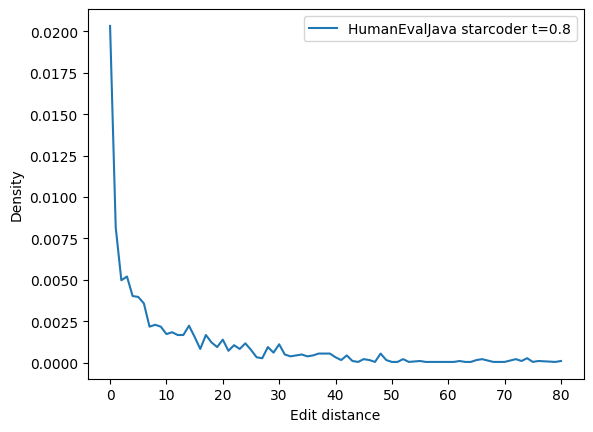

In [43]:
# We have a list of identifiers and a list of edit distances
# We want a line plot of multiple lines
# - x-axis is the edit distance
# - y-axis is the ratio of samples that have an equal edit-distance
from functools import reduce
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Tuple

identifiers = [e["identifier"] for e in conf_list]
for i, dists in enumerate(dists_list):
    d_full = filter(None, dists)  # Remove None values
    d_full = reduce(lambda x, y: x + y, d_full)  # Flatten the list
    d_full = list(d_full)
    total = sum(d_full)
    count = Counter(d_full)
    x, y = zip(*sorted(count.items(), key=lambda x: x[0]))
    y = [c / total for c in y]
    plt.plot(x, y, label=identifiers[i])
plt.xlabel("Edit distance")
plt.ylabel("Density")
plt.legend()

plt.show()

In [58]:
len(dists_list), len(dists_list[0]), len(dists_list[0][0])

(2, 162, 10)